In [1]:
import sys
try:
    del sys.modules["spnhelp"]
except:
    pass
import spnhelp
try:
    del sys.modules["clg"]
except:
    pass
from clg import noise, Norm
from math import sqrt
from spn.io.Text import spn_to_str_equation
import pandas as pd
from spn.structure.leaves.parametric.Parametric import Gaussian, Uniform
import numpy as np
import matplotlib.pyplot as plt
from spn.structure.Base import get_number_of_nodes, get_depth
from spn.algorithms.Inference import likelihood
import scipy.stats as stats
from IPython.display import display

     X    Y    Z    J
X  0.0  0.0  0.0  0.0
Y  0.0  0.0  0.0  0.0
Z  0.0  0.0  1.0  1.0
J  0.0  0.0  1.0  2.0


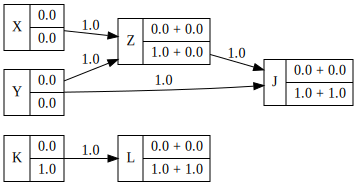

In [2]:

W = "X" @ noise
X = "X" @ noise
Y = "Y" @ noise
Z = "Z" @ (X + Y + noise)
J = "J" @ (Z + noise + Y)

K = "K" @ noise
L = "L" @ (K + noise)

Z & L
X.condition(0)
Y.condition(0)
print(X.get_Σ())
# samples = X.forward_sample(10000)
# print(np.cov(samples, rowvar=False))
X.get_graph(True)

     X    Y    Z    J
X  1.0  0.0  1.0  1.0
Y  0.0  1.0  1.0  2.0
Z  1.0  1.0  3.0  4.0
J  1.0  2.0  4.0  7.0


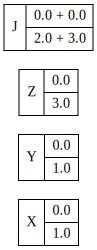

In [3]:
copy = X.deepcopy()
copy.castrate_roots()

print(copy.get_Σ())
np.linalg.inv(copy.get_Σ())
copy.get_graph(True)

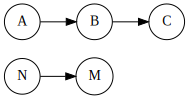

     A    B    C
A  1.0  1.0  1.0
B  1.0  2.0  2.0
C  1.0  2.0  3.0
[[ 1.1  1.1  0.  -0.  -0. ]
 [ 1.1  2.   0.   0.   0. ]
 [ 0.   0.   1.1  1.1  1.1]
 [-0.   0.   1.1  2.2  2.2]
 [-0.   0.   1.1  2.2  3.2]]


In [4]:
from itertools import product
from spn.structure.Base import Node, Sum, Product, assign_ids, rebuild_scopes_bottom_up



A = "A" @ noise
B = "B" @ (A + noise + 1)
# I = "I" @ noise
C = "C" @ (B + noise + 1)
# C = "C" @ (A + noise + 3)
# D = "D" @ (B + C + noise - 4)

N = "N" @ (noise - 3)
M = "M" @ (N + noise - 2)

A & N

display(A.get_graph())
print(A.get_Σ())

spn = spnhelp.pgm_to_spn(A, eps = 0.05)
samples = spnhelp.sample_from_spn(spn, 10000)
print(np.cov(samples, rowvar=False).round(1))

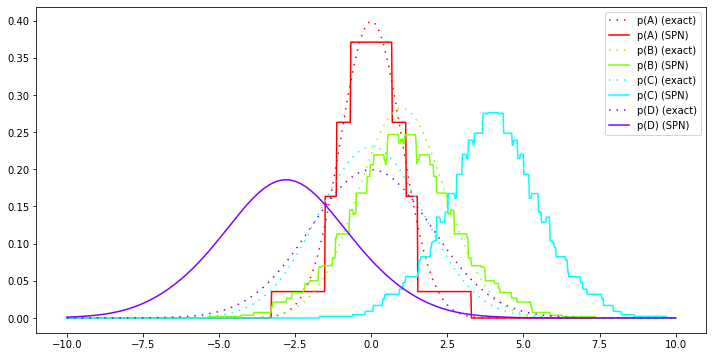

In [12]:
plt.rcParams["figure.figsize"] = (12, 6)
spnhelp.plot_marginals(spn, A)

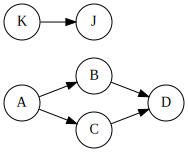

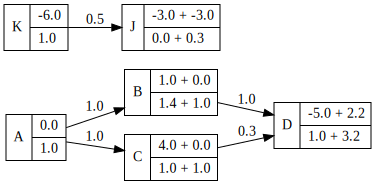

In [7]:
A = "A" @ noise  # noise is an i.i.d. gaussian with mean 0 and variance 1. The @ operator assigns a name to the variable.
B = "B" @ (A + 1.2*noise + 1) # They can be composed with other variables, and more noise can be added.
C = "C" @ (A + noise + 4)
D = "D" @ (B + 0.3*C + noise - 5)

K = "K" @ (noise - 6)
J = "J" @ (0.5 * K - 3 + 0.2*noise)
A & K # Here, we join the two pgms, which have no connecting edges between them.
display(A.get_graph(detailed=False))
display(A.get_graph(detailed=True))

2338 nodes, with depth of 11


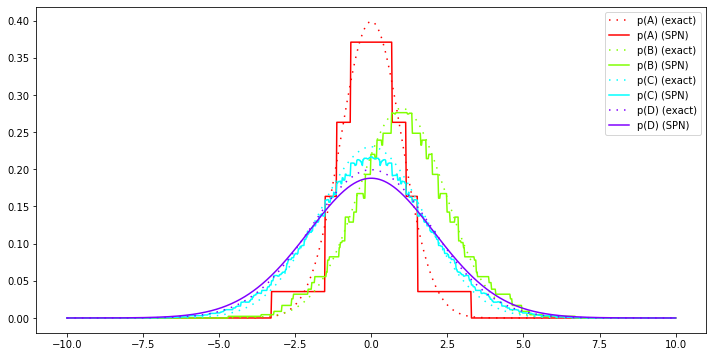

In [13]:
spn = spnhelp.pgm_to_spn(A, eps = 0.1)
spnhelp.plot_marginals(spn, A)
print(get_number_of_nodes(spn), "nodes, with depth of", get_depth(spn))

In [9]:
scope = A.get_scope(across_factors=True)
print(K.get_Σ())
print(A.get_Σ())
samples = spnhelp.sample_from_spn(spn, 10000)
cov = np.cov(samples, rowvar=False).round(1)
print(pd.DataFrame(cov, index=scope, columns=scope))

     K     J
K  1.0  0.50
J  0.5  0.29
     A     B    C     D
A  1.0  1.00  1.0  1.30
B  1.0  2.44  1.0  2.74
C  1.0  1.00  2.0  1.60
D  1.3  2.74  1.6  4.22
     A    B    C    D    K    J
A  1.3  1.2  1.2  1.5  0.0 -0.0
B  1.2  3.0  1.2  3.2 -0.0 -0.0
C  1.2  1.2  2.5  1.9 -0.0 -0.0
D  1.5  3.2  1.9  4.8 -0.0 -0.0
K  0.0 -0.0 -0.0 -0.0  1.3  0.6
J -0.0 -0.0 -0.0 -0.0  0.6  0.3


In [10]:
scope = A.get_scope(across_factors=True)
print(K.get_µ())
print(A.get_µ())
samples = spnhelp.sample_from_spn(spn, 10000)
mean = np.mean(samples, axis=0).round(1)
print(pd.Series(mean, index=scope))

K   -6.0
J   -6.0
dtype: float64
A    0.0
B    1.0
C    4.0
D   -2.8
dtype: float64
A    0.0
B    1.0
C    4.0
D   -2.8
K   -6.0
J   -6.0
dtype: float64


[2248105685296, 2248105688128, 2248105687792, 2248139757344]
     A    B    C    D
A  1.0  1.0  1.0  1.0
B  1.0  2.0  2.0  2.0
C  1.0  2.0  3.0  3.0
D  1.0  2.0  3.0  4.0


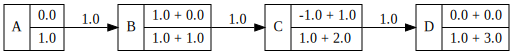

[2248139760320, 2248139760176, 2248143324928]
     B    C    D
B  2.0  2.0  2.0
C  2.0  3.0  3.0
D  2.0  3.0  4.0


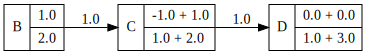

[2248139956448, 2248139952992]
     C    D
C  3.0  3.0
D  3.0  4.0


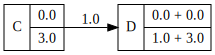

[2248139881248]
     D
D  4.0


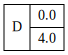

In [11]:

A = "A" @ noise
"D" @ ("C" @ ("B" @ (A + noise + 1) + noise - 1) + noise)
# "C" @ (A + noise)
# "D" @ (A + noise)


B = A.deepcopy().castrate_roots()
C = B.deepcopy().castrate_roots()
D = C.deepcopy().castrate_roots()

for x in [A, B, C, D]:
    print(list(map(lambda n: id(n) , x.get_nodes())))
    print(x.get_Σ())
    display(x.get_graph(True))